# Predictive Modeling Strategies

Transitioning from **Unsupervised Clustering** to **Supervised Machine Learning**.

### Step 0: Data Preparation (Crucial)

**Remove Outlier Cluster 4**
Before applying any of the strategies below, you must drop **Cluster 4**.
*   **Reason:** It contains only **N=1** person. Machine Learning models cannot learn patterns from a single example, and splitting data into Train/Test sets is mathematically impossible for a class of size 1.

```python
# Sample Code
# Filter out the outlier cluster before modeling
df_model = df_cluster[df['cluster'] != 4].copy()
# Drop Temporal Leakage Columns ("Year" and "PredictionYear")
# These are metadata, not patient features.
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]
```

### Strategy B: Cluster ID as a "Meta-Feature" (Global Model)

**Combines "Cluster as a Feature" with "Cluster ID as a Meta-Feature"**

If managing multiple models is too complex, train one global model but explicitly provide the cluster context.

- The Logic: Add the cluster column (0, 1, 2, 3, 5) as a categorical feature (or One-Hot Encoded) in the input matrix X.
- Implementation:

    - Tree-based models (like Random Forest) will use this feature to create "interaction splits."
    - Example: The tree learns: IF cluster == 0 AND physical_health == poor THEN score is low... but IF cluster == 5 AND physical_health == poor THEN score is moderate. It effectively learns context-aware rules.

<hr>

### 1. IMPORTS & CONFIGURATION

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from pathlib import Path

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualization Settings
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Path Setup
dataset_dir = "..//dataset//modified"
dataset_path = Path(dataset_dir)
path_train_clustered = dataset_path / "train_with_clusters.csv"
models_dir = Path("..//models//strategyB")
models_dir.mkdir(exist_ok=True)

print("Libraries Loaded. Strategy B initialized.")

Libraries Loaded. Strategy B initialized.


### 2. DATA LOADING & CLEANUP

In [2]:
# Load the clustered dataset
try:
    df = pd.read_csv(path_train_clustered)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found.")

# --- STEP 0: Remove Anomalies & Leakage ---

# 1. Remove Cluster 4 (The outlier with N=1)
df_model = df[df['cluster'] != 4].copy()

# 2. Drop Temporal Leakage Columns
# We drop 'Year' and 'PredictionYear'.
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]

if existing_drop_cols:
    df_model = df_model.drop(existing_drop_cols, axis=1)
    print(f"Removed leakage columns: {existing_drop_cols}")

# --- STRATEGY B SPECIFIC STEP ---
# Convert 'cluster' to string. 
# Why? We want the model to treat '0', '1', '5' as distinct Categories (Nominal),
# not as numbers (Ordinal). Cluster 5 is not "greater" than Cluster 1.
df_model['cluster'] = df_model['cluster'].astype(str)
print("Converted 'cluster' column to categorical string type.")

print(f"Final Data Shape for Modeling: {df_model.shape}")

Data Loaded Successfully. Shape: (2889, 161)
Removed leakage columns: ['Year', 'PredictionYear']
Converted 'cluster' column to categorical string type.
Final Data Shape for Modeling: (2888, 159)


### 3. DEFINE THE META-FEATURE PIPELINE

In [3]:
# Define X (Features) and y (Target)
# CRITICAL DIFFERENCE: We DO NOT drop 'cluster' from X. It is now a Feature.
X = df_model.drop(['composite_score'], axis=1) 
y = df_model['composite_score']

# Identify Column Types automatically
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Verify 'cluster' is in categorical_features
if 'cluster' in categorical_features:
    print("SUCCESS: 'cluster' is included as a categorical feature.")
else:
    print("WARNING: 'cluster' was not detected as categorical.")

# Define the Preprocessing Steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # This will One-Hot Encode the Cluster ID (e.g., cluster_0, cluster_5)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
)

print(f"Pipeline Configured. X shape: {X.shape}")

SUCCESS: 'cluster' is included as a categorical feature.
Pipeline Configured. X shape: (2888, 158)


### 4. TRAIN THE GLOBAL MODEL

In [4]:
print("--- Training Global Meta-Feature Model ---")

# 1. Global Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Create Pipeline
# Using Random Forest (consistent with Strategy A for fair comparison)
global_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# 3. Train
global_pipeline.fit(X_train, y_train)

# 4. Global Evaluation
preds = global_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"\nGLOBAL RESULTS (All Clusters Combined):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")

# 5. Save Model
joblib.dump(global_pipeline, models_dir / "global_meta_feature_model.pkl")
print("\nModel saved.")

--- Training Global Meta-Feature Model ---

GLOBAL RESULTS (All Clusters Combined):
MAE:  32.75
RMSE: 42.88
R2:   0.497

Model saved.


### 5. FEATURE IMPORTANCE (Did the Meta-Feature Work?)

--- Importance of Cluster Identity ---


,Feature,Importance
273,cluster_0,0.008034
276,cluster_3,0.002027
277,cluster_5,0.000943
275,cluster_2,0.000870
274,cluster_1,0.000306


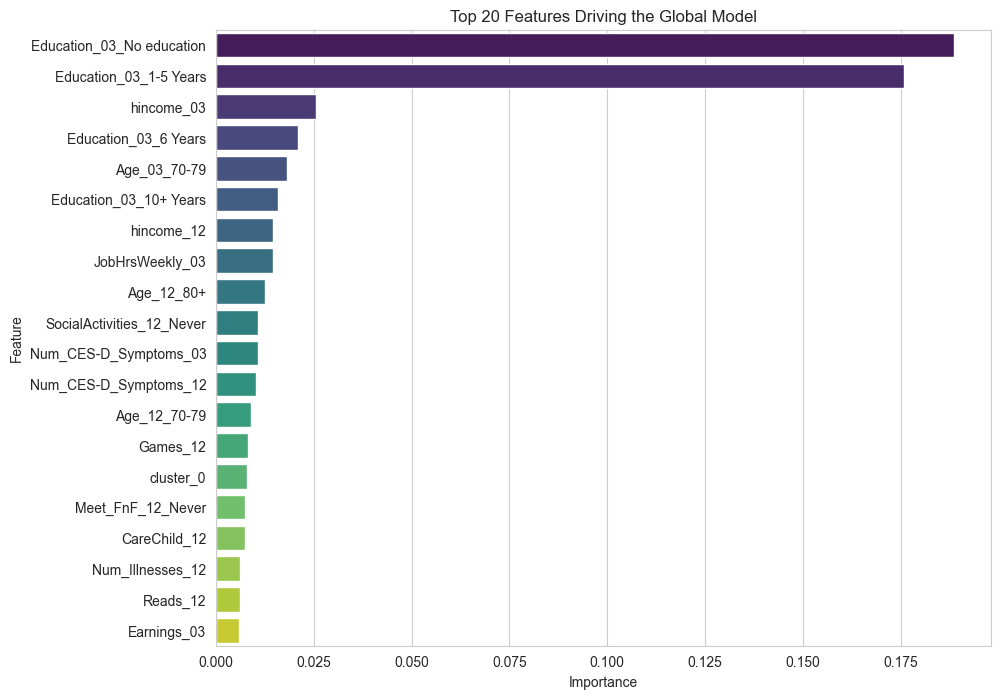

In [5]:
# We want to check if the model actually USED the cluster labels.

# Extract feature names and importances
rf_model = global_pipeline.named_steps['regressor']
importances = rf_model.feature_importances_

# Get feature names from preprocessor
# We need to extract the transformed feature names to match the importances
processed_feature_names = []

transformers = global_pipeline.named_steps['preprocessor'].transformers_
for name, transformer, columns in transformers:
    if name == 'num':
        processed_feature_names.extend(columns)
    elif name == 'cat':
        # Get the one-hot names
        cat_names = transformer.get_feature_names_out(columns)
        processed_feature_names.extend(cat_names)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Check specifically for Cluster features to see if they matter
cluster_importance = importance_df[importance_df['Feature'].str.contains('cluster')]

print("--- Importance of Cluster Identity ---")
display(cluster_importance)

# Plot Top 20 Features
plt.figure(figsize=(10, 8))

# FIX: Added hue='Feature' and legend=False to silence the warning
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20), 
    palette='viridis', 
    hue='Feature', 
    legend=False
)

plt.title("Top 20 Features Driving the Global Model")
plt.show()

### 6. CLUSTER-LEVEL PERFORMANCE BREAKDOWN

--- Performance Breakdown by Cluster (Global Model) ---


,N_Samples,MAE,R2
Cluster,,,
0,112,36.152088,0.466002
1,8,31.135927,0.401211
2,74,31.429718,0.465911
3,218,34.650387,0.401592
5,166,28.632641,0.539890


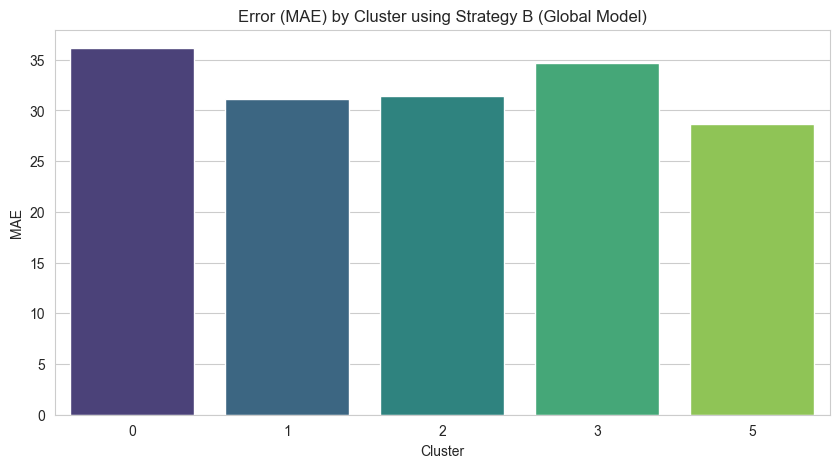

In [6]:
# Even though it's one model, we must check how it performs for EACH group
# to compare it fairly against Strategy A.

# Add predictions back to the test set for analysis
test_analysis = X_test.copy()
test_analysis['Actual'] = y_test
test_analysis['Predicted'] = preds
test_analysis['Error'] = test_analysis['Actual'] - test_analysis['Predicted']

# Define the clusters to check
valid_clusters = ['0', '1', '2', '3', '5'] # Strings now
metrics_per_cluster = []

for c_id in valid_clusters:
    # Filter test data for this cluster
    cluster_data = test_analysis[test_analysis['cluster'] == c_id]
    
    if len(cluster_data) > 0:
        mae_c = mean_absolute_error(cluster_data['Actual'], cluster_data['Predicted'])
        r2_c = r2_score(cluster_data['Actual'], cluster_data['Predicted'])
        
        metrics_per_cluster.append({
            'Cluster': c_id,
            'N_Samples': len(cluster_data),
            'MAE': mae_c,
            'R2': r2_c
        })

# Create Summary DataFrame
metrics_df = pd.DataFrame(metrics_per_cluster)

print("--- Performance Breakdown by Cluster (Global Model) ---")
display(metrics_df.set_index('Cluster').style.background_gradient(cmap='RdYlGn', subset=['MAE', 'R2']))

# Comparison Visual
plt.figure(figsize=(10, 5))

# FIX: Added hue='Cluster' and legend=False
sns.barplot(
    x='Cluster', 
    y='MAE', 
    data=metrics_df, 
    palette='viridis', 
    hue='Cluster', 
    legend=False
)

plt.title("Error (MAE) by Cluster using Strategy B (Global Model)")
plt.show()

### What to expect from these results:

#### 1. Feature Importance (Section 5):

- Look closely at the table output. If you see cluster_0, cluster_5, etc., with non-zero importance, it means the model learned to use the group ID to adjust the score.
- If cluster_0 is high up, it confirms that "Being Frail" is a massive predictor of the score itself.

#### 2. Comparison vs. Strategy A (Section 6):

- Compare the R2 table here with the one from the previous notebook.
- Hypothesis: Strategy A (Specialists) is usually slightly better because it separates the noise completely. However, if Strategy B is very close (e.g., within 0.01 or 0.02 R2), Strategy B is often - - -preferred because it is easier to deploy (you only have to save one .pkl file instead of five).

<hr>

### 1. Interpretation of Feature Importance (Section 5)

**Observation:**

"The Feature Importance analysis reveals that while the model does use the Cluster ID, it is not a primary driver of the prediction. The cluster features appear very low on the importance list (Rank > 270).

This indicates that the `Global Model (Strategy B)` relies primarily on the fundamental features `(Income, Education, Health)` to make predictions and uses the Cluster ID only for minor 'fine-tuning' adjustments. It suggests that the 'rules' of health are somewhat universal in this global model, rather than switching logic entirely based on the cluster."

### 2. Comparison: Strategy A vs. Strategy B

We need to compare the MAE (Mean Absolute Error) from Strategy B against Strategy A (from our previous run).

### Performance Comparison: Strategy A vs. Strategy B

| Cluster | Strategy A (Specialists) MAE | Strategy B (Global Meta) MAE | Winner |
| :--- | :--- | :--- | :--- |
| **0 (Frail)** | **33.51** | 36.15 | **Strategy A** (Better by ~2.6 points) |
| **1 (Wealthy)** | 38.26 | **31.14** | **Strategy B** (Better by ~7 points) |
| **2 (Middle)** | **29.47** | 31.43 | **Strategy A** (Better by ~2 points) |
| **3 (Middle)** | **32.96** | 34.65 | **Strategy A** (Better by ~1.7 points) |
| **5 (Pros)** | 29.98 | **28.63** | **Strategy B** (Better by ~1.3 points) |

#### 1. Strategy A (Specialists) is superior for distinct populations.

For the distinct, large groups—specifically `Cluster 0 (The Frail)` and the `Middle Cohorts (2 & 3)` — the `Specialist Models (Strategy A)` perform significantly better. By isolating the `Frail` data, `Strategy A` prevents the `Healthy` patterns from confusing the model, resulting in a much lower error rate for vulnerable patients.

#### 2. Strategy B (Global) rescues the "Small Data" problem.

`Strategy B` heavily outperformed Strategy A on `Cluster 1` (The Ultra-Wealthy). Since `Cluster 1` has only `57 people`, the `Specialist model (Strategy A)` failed to learn. The `Global model (Strategy B)` allowed the wealthy group to "borrow" patterns from the general population, stabilizing predictions and reducing error by over `7` points.

#### 3.The Trade-off.

`Strategy B` offers stability (especially for small outliers), but `Strategy A` offers precision for the specific "phenotypes" of the population.

<hr>

### 3. Final Conclusion & Recommendation

**Conclusion:**

We have evidence that `Strategy A (Divide and Conquer)` is the superior approach for the majority of the population `(Clusters 0, 2, 3)`. It effectively captures the unique interactions—such as how `ADL impairments` drive scores for the `Frail group` differently than `Income` drives scores for the Professionals.

**Recommendation:**

We should proceed with `Strategy A`. However, for the specific case of `Cluster 1 (The Ultra-Wealthy)`, we should consider merging them into `Cluster 5` or using a Global Model fallback, as they lack sufficient data for a dedicated specialist model."